In [ ]:
# Importing essential libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing specific modules from libraries
from torchvision import transforms
from os import path
from scipy.ndimage import rotate
from torch import nn
from sklearn.metrics import confusion_matrix

# Importing utility modules
import random
from torch.utils.data import Dataset, DataLoader, sampler
from copy import deepcopy
import nibabel as nib

In [ ]:
!wget --show-progress --verbose --tries=3 --no-check-certificate https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz

--2024-05-31 02:50:32--  https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz
Resolving aramislab.paris.inria.fr (aramislab.paris.inria.fr)... 128.93.101.235
Connecting to aramislab.paris.inria.fr (aramislab.paris.inria.fr)|128.93.101.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1387416064 (1.3G) [application/octet-stream]
Saving to: ‘OASIS-1-dataset_pt_new.tar.gz’

OASIS-1-dataset_pt_ 100%[===================>]   1.29G  15.9MB/s    in 89s     

2024-05-31 02:52:03 (14.8 MB/s) - ‘OASIS-1-dataset_pt_new.tar.gz’ saved [1387416064/1387416064]



In [ ]:
! tar xf OASIS-1-dataset_pt_new.tar.gz -C ./

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

  diagnosis_bl laterality   MMS  cdr_global diagnosis  
0           CN          R  29.0         0.0        CN  
1           CN          R  29.0         0.0        CN  
2           AD          R  27.0         0.5        AD  
3           CN          R  30.0         NaN        CN  
4           CN          R  30.0         NaN        CN  


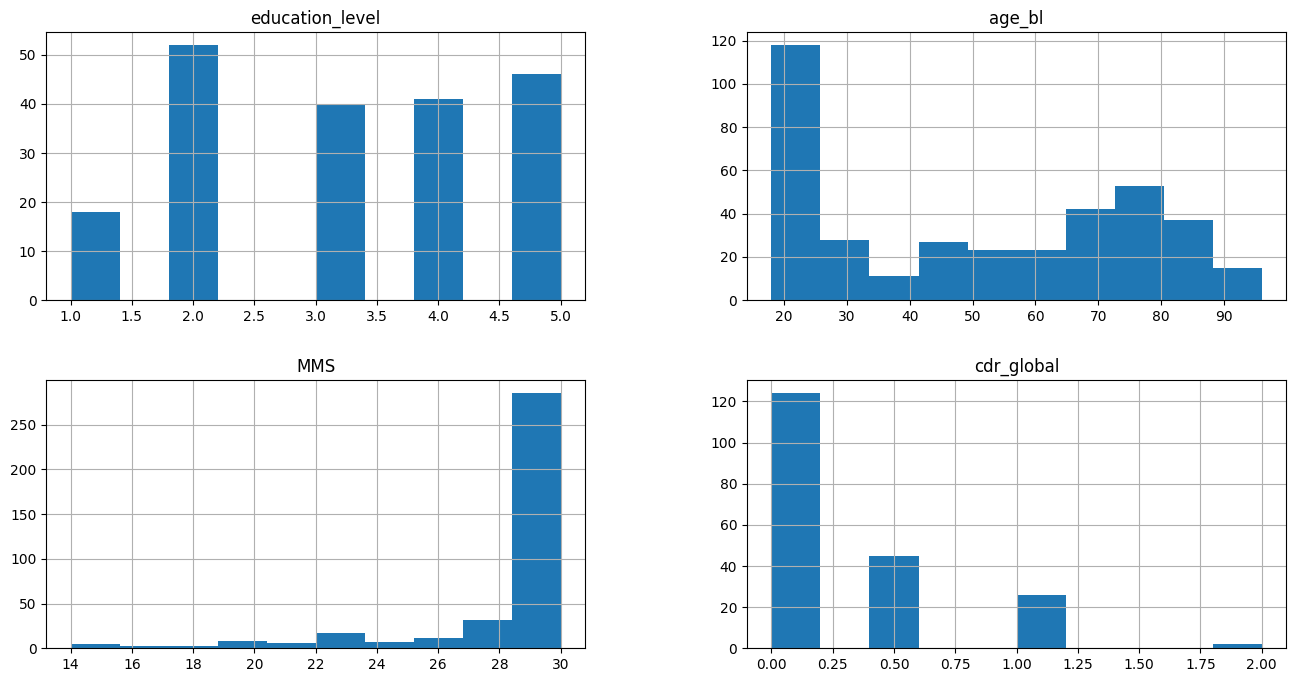

In [ ]:
# File path
file_path = 'OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv'

# Columns to load
columns_to_load = [
    'participant_id', 'session_id', 'alternative_id_1', 'sex',
    'education_level', 'age_bl', 'diagnosis_bl', 'laterality', 'MMS',
    'cdr_global', 'diagnosis']

# Read the CSV file using pandas of dataset
df_data = pd.read_csv(file_path, sep='\t', usecols=columns_to_load)
# Show first five items of the table
print(df_data.head())
# First visual inspection
_ = df_data.hist(figsize=(16, 8))

In [ ]:
class ds_MRI(Dataset):

    def __init__(self, image_directory, df_dataset, list_transforms=None):

        self.image_directory = image_directory
        self.list_transforms = list_transforms
        self.df_dataset = df_dataset
        self.diagnostic_code = {"AD": 1, "CN": 0}
        # Set the size attribute based on the shape of the first image in the dataset
        if len(self.df_dataset) > 0:
            self.size = self.__getitem__(0)['image'].shape
        else:
            raise ValueError("The dataset is empty, cannot determine image shape.")

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):

        diag_stage = self.df_dataset.loc[idx, 'diagnosis']
        diagnosis_label = self.diagnostic_code[diag_stage]

        patient_id = self.df_dataset.loc[idx, 'participant_id']
        assignment_id = self.df_dataset.loc[idx, 'session_id']
        patient_file = (
            f'subjects/{patient_id}/{assignment_id}/'
            f'deeplearning_prepare_data/image_based/custom/'
            f'{patient_id}_{assignment_id}_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'
        )

        patient_image = torch.load(path.join(self.image_directory, patient_file))

        if self.list_transforms:
            patient_image = self.list_transforms(patient_image)

        sample = {'image': patient_image, 'label': diagnosis_label,
                  'participant_id': patient_id,
                  'session_id': assignment_id}
        return sample

    def train(self):
        self.list_transforms.train()

    def eval(self):
        self.list_transforms.eval()

In [ ]:
class CropRightHippoCampus(object):
    """Crops the right hippocampus of a MRI"""

    def __init__(self, rndm_move=0):
        self.rndm_move = rndm_move
        self.training_mode = True

    def __call__(self, img):
        if self.training_mode:
            x_dir = random.randint(-self.rndm_move, self.rndm_move)
            y_dir = random.randint(-self.rndm_move, self.rndm_move)
            z_dir = random.randint(-self.rndm_move, self.rndm_move)
        else:
            x_dir, y_dir, z_dir = 0, 0, 0

        # Calculate the indices for cropping
        x_start, x_end = 65 + x_dir, 95 + x_dir
        y_start, y_end = 50 + y_dir, 90 + y_dir
        z_start, z_end = 27 + z_dir, 57 + z_dir

        # Perform the crop and clone the resulting tensor
        return img[:, x_start:x_end, y_start:y_end, z_start:z_end].clone()

    def train(self):
        self.training_mode = True

    def eval(self):
        self.training_mode = False

In [ ]:
ds_train = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
ds_test = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

class PadMaxPool3d(nn.Module):

    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
            super().__init__()
            self.kernel_size = kernel_size
            self.stride = stride
            self.return_indices = return_indices
            self.return_pad = return_pad

            # Initialize the pooling and padding layers
            self.pool = nn.MaxPool3d(kernel_size=kernel_size, stride=stride, return_indices=return_indices)
            self.pad = nn.ConstantPad3d(padding=0, value=0)

    def forward(self, temp_map):
        coords = []
        for i in range(3):
            size = temp_map.size(i + 2)
            remainder = size % self.stride
            adjustment = self.stride - remainder
            coords.append(adjustment)

        coords = [0 if coord == self.stride else coord for coord in coords]

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, indices, padding_info
            else:
                return output, indices

        else:
            output = self.pool(self.pad(temp_map))

            if self.return_pad:
                padding_info = (coords[2], 0, coords[1], 0, coords[0], 0)
                return output, padding_info
            else:
                return output

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BottleneckBlock3D(nn.Module):
    expansion = 4  # ResNet-50 uses an expansion factor of 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv3 = nn.Conv3d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)))
        out = F.leaky_relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out)
        return out

class CustomResNet3D(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(CustomResNet3D, self).__init__()
        self.in_channels = 8  # This initial number of channels must be carefully set according to the input and model structure

        self.conv1 = nn.Conv3d(1, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_channels)
        self.layer1 = self._make_layer(block, 8, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 16, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 32, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * block.expansion, num_classes)  # Adjust output dimensions according to the last layer and the expansion factor

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool3d(x, (1, 1, 1))
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


In [ ]:
import torch.nn as nn

def train(model, train_loader, val_loader, criterion, optimizer, n_epochs):

    best_model = deepcopy(model)
    train_best_loss = np.inf
    losses = {'train': [], 'val': []}

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        count = 0

        for data in train_loader:
            images, labels = data['image'].cuda(), data['label'].cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            count += 1

        train_loss = total_loss / count
        losses['train'].append(train_loss)

        # Validation loss
        model.eval()
        total_val_loss = 0
        val_count = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data['image'].cuda(), data['label'].cuda()
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
                val_count += 1

        val_loss = total_val_loss / val_count
        losses['val'].append(val_loss)

        print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}")

        if val_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = val_loss

    return best_model, losses

def plot_losses_per_lr(losses_dict):
    """
    Plots training and validation losses for each learning rate in separate graphs.

    Args:
        losses_dict: Dictionary where key is the learning rate and value is another dict
                     containing 'train' and 'val' losses lists.
    """
    for lr, losses in losses_dict.items():
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(losses['train'], label='Training Loss', color='blue')
        plt.title(f'Training Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(losses['val'], label='Validation Loss', color='red')
        plt.title(f'Validation Loss (LR={lr})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def test(model, data_loader, criterion):

    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1", "true_label", "predicted_label"]
    final_df = pd.DataFrame(columns=columns)
    total_loss = 0

    # Disable gradient computation for validation/testing
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # Move images and labels to GPU
            images = data['image'].cuda()
            labels = data['label'].cuda()
            # Forward pass: compute predicted outputs
            outputs = model(images)
            # Compute the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Compute probabilities using Softmax
            probs = nn.Softmax(dim=1)(outputs)
            # Get the predicted class with the highest probability
            _, predicted = torch.max(outputs.data, 1)
            # Prepare data for the results DataFrame
            rows = [
                [
                    data['participant_id'][idx],
                    probs[idx, 0].item(),
                    probs[idx, 1].item(),
                    labels[idx].item(),
                    predicted[idx].item()
                ]
                for idx in range(len(data['participant_id']))
            ]

            # Create a DataFrame from the rows and concatenate to the results DataFrame
            batch_df = pd.DataFrame(rows, columns=columns)
            final_df = pd.concat([final_df, batch_df], ignore_index=True)

    # Convert the true_labels and predicted_labels to integers

    true_labels = final_df['true_label'].to_numpy(dtype=int)
    predicted_labels = final_df['predicted_label'].to_numpy(dtype=int)

    # Print unique values and types for debugging
    print("True labels unique values:", np.unique(true_labels), "Type:", true_labels.dtype)
    print("Predicted labels unique values:", np.unique(predicted_labels), "Type:", predicted_labels.dtype)

    # Compute metrics for true and predicted labels
    final_metrics = compute_metrics(true_labels, predicted_labels)

    # Reset the index of the results DataFrame
    final_df.reset_index(drop=True, inplace=True)

    # Calculate mean loss and add it to the results metrics
    mean_loss = total_loss / len(data_loader.dataset)
    final_metrics['mean_loss'] = mean_loss

    return final_df, final_metrics

def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity, balanced accuracy, and confusion matrix"""
    # Ensure that ground_truth and prediction are numpy arrays
    ground_truth = np.array(ground_truth)
    prediction = np.array(prediction)

    # Compute confusion matrix
    cm = confusion_matrix(ground_truth, prediction)

    true_positives = np.sum((prediction == 1) & (ground_truth == 1))
    true_negatives = np.sum((prediction == 0) & (ground_truth == 0))
    false_positives = np.sum((prediction == 1) & (ground_truth == 0))
    false_negatives = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

    # Sensitivity
    if true_positives + false_negatives != 0:
        metrics_dict['sensitivity'] = true_positives / (true_positives + false_negatives)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if false_positives + true_negatives != 0:
        metrics_dict['specificity'] = true_negatives / (false_positives + true_negatives)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2
    metrics_dict['confusion_matrix'] = cm

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return metrics_dict

def plot_separate_losses(loss_history):
    """
    Function to plot training and validation losses on separate graphs for the best performing model.

    Args:
        loss_history: (dict) containing lists of training and validation losses
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history['train'], label='Training Loss', color='blue')
    plt.title('Training Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss_history['val'], label='Validation Loss', color='red')
    plt.title('Validation Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def display_confusion_matrix(conf_matrix):
    """
    Displays the confusion matrix using seaborn heatmap.

    Args:
        conf_matrix: (numpy array) the confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for Best Model')
    plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.6627, Val loss = 10.8301
Epoch 1: Train loss = 1.5482, Val loss = 10.0311
Epoch 2: Train loss = 1.4123, Val loss = 8.7173
Epoch 3: Train loss = 1.2416, Val loss = 9.9540
Epoch 4: Train loss = 1.1362, Val loss = 17.6967
Epoch 5: Train loss = 1.2126, Val loss = 8.5216
Epoch 6: Train loss = 1.0682, Val loss = 52.3571
Epoch 7: Train loss = 1.1428, Val loss = 14.9606
Epoch 8: Train loss = 0.9935, Val loss = 13.9340
Epoch 9: Train loss = 1.0230, Val loss = 14.0913
Epoch 10: Train loss = 0.9465, Val loss = 8.7177
Epoch 11: Train loss = 0.9716, Val loss = 64.2286
Epoch 12: Train loss = 1.2384, Val loss = 7.3933
Epoch 13: Train loss = 1.1134, Val loss = 10.2046
Epoch 14: Train loss = 0.8612, Val loss = 8.9475
Epoch 15: Train loss = 1.0560, Val loss = 6.2576
Epoch 16: Train loss = 0.8392, Val loss = 7.4391
Epoch 17: Train loss = 0.6927, Val loss = 21.4977
Epoch 18: Train loss = 0.8758, Val loss = 8.7791
Epoch 19: Train loss = 0.9476, Val loss = 7.0260
Epoch 20: Train loss

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[59  3]
 [ 5 10]]


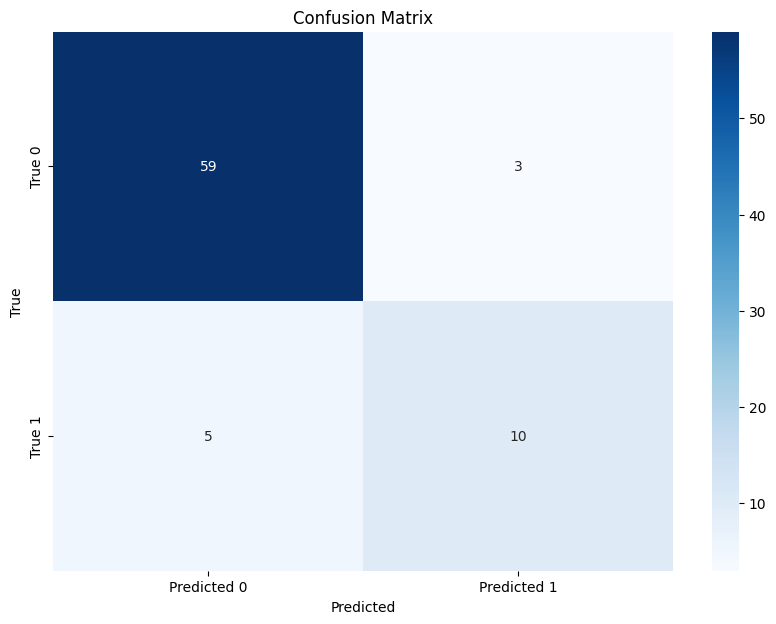

Learning Rate: 0.001 - Validation Accuracy: 0.8961038961038961


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.8627, Val loss = 12.8357
Epoch 1: Train loss = 1.3194, Val loss = 7.5474
Epoch 2: Train loss = 1.3296, Val loss = 14.0637
Epoch 3: Train loss = 1.0720, Val loss = 12.1011
Epoch 4: Train loss = 0.9174, Val loss = 22.2888
Epoch 5: Train loss = 0.7806, Val loss = 10.0803
Epoch 6: Train loss = 0.8521, Val loss = 13.1374
Epoch 7: Train loss = 0.6467, Val loss = 8.1930
Epoch 8: Train loss = 0.3275, Val loss = 15.7400
Epoch 9: Train loss = 0.4653, Val loss = 9.5796
Epoch 10: Train loss = 0.4041, Val loss = 8.6288
Epoch 11: Train loss = 0.6323, Val loss = 12.1814
Epoch 12: Train loss = 0.4285, Val loss = 12.5210
Epoch 13: Train loss = 0.4897, Val loss = 7.0877
Epoch 14: Train loss = 0.2062, Val loss = 10.2499
Epoch 15: Train loss = 0.0501, Val loss = 11.8882
Epoch 16: Train loss = 0.0109, Val loss = 12.0280
Epoch 17: Train loss = 0.0076, Val loss = 12.5914
Epoch 18: Train loss = 0.0059, Val loss = 12.9723
Epoch 19: Train loss = 0.1303, Val loss = 13.0310
Epoch 20: Train

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[55  7]
 [ 3 12]]


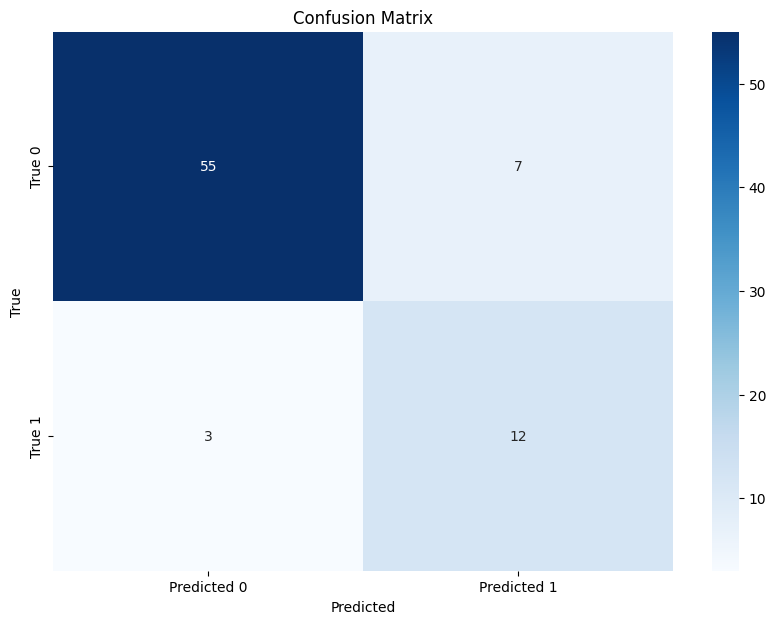

Learning Rate: 0.0005 - Validation Accuracy: 0.8701298701298701


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 1.9333, Val loss = 10.4935
Epoch 1: Train loss = 1.3666, Val loss = 10.1655
Epoch 2: Train loss = 1.4314, Val loss = 9.8992
Epoch 3: Train loss = 1.2232, Val loss = 8.0667
Epoch 4: Train loss = 1.0767, Val loss = 8.0464
Epoch 5: Train loss = 1.0984, Val loss = 13.3871
Epoch 6: Train loss = 1.1067, Val loss = 9.8412
Epoch 7: Train loss = 0.8754, Val loss = 8.5321
Epoch 8: Train loss = 0.8516, Val loss = 9.0064
Epoch 9: Train loss = 0.9132, Val loss = 9.7997
Epoch 10: Train loss = 0.9200, Val loss = 16.7544
Epoch 11: Train loss = 0.9853, Val loss = 9.4524
Epoch 12: Train loss = 0.6914, Val loss = 9.1467
Epoch 13: Train loss = 0.6084, Val loss = 29.2184
Epoch 14: Train loss = 0.6811, Val loss = 13.9278
Epoch 15: Train loss = 0.7150, Val loss = 7.9979
Epoch 16: Train loss = 0.4423, Val loss = 12.3561
Epoch 17: Train loss = 0.4484, Val loss = 12.9781
Epoch 18: Train loss = 0.5143, Val loss = 13.4675
Epoch 19: Train loss = 0.3342, Val loss = 11.1461
Epoch 20: Train loss

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[56  6]
 [ 5 10]]


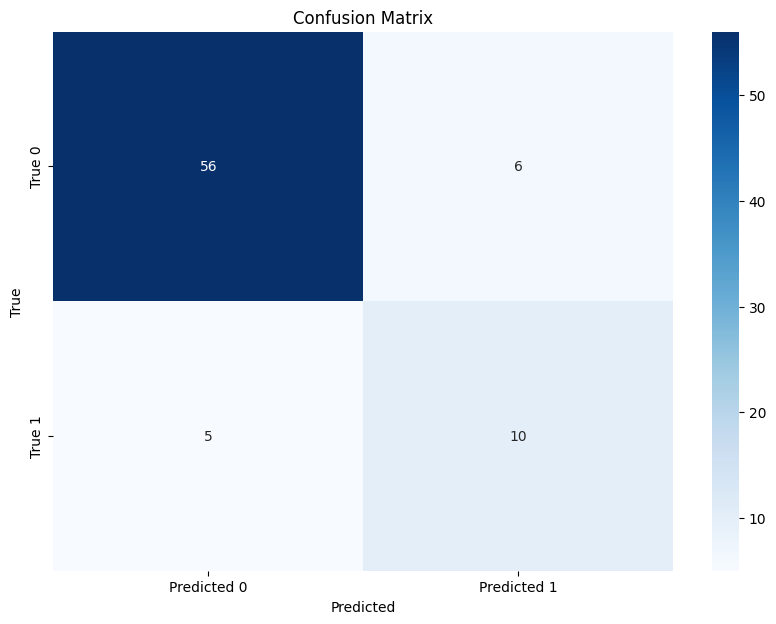

Learning Rate: 0.0001 - Validation Accuracy: 0.8571428571428571


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 2.5892, Val loss = 12.5167
Epoch 1: Train loss = 1.9203, Val loss = 12.5200
Epoch 2: Train loss = 1.7018, Val loss = 13.5142
Epoch 3: Train loss = 1.5266, Val loss = 12.8044
Epoch 4: Train loss = 1.3306, Val loss = 11.5366
Epoch 5: Train loss = 1.1765, Val loss = 9.8267
Epoch 6: Train loss = 1.0353, Val loss = 8.9694
Epoch 7: Train loss = 1.1235, Val loss = 9.3299
Epoch 8: Train loss = 0.9599, Val loss = 8.5859
Epoch 9: Train loss = 0.8986, Val loss = 9.4550
Epoch 10: Train loss = 0.8681, Val loss = 9.8271
Epoch 11: Train loss = 0.8243, Val loss = 10.8290
Epoch 12: Train loss = 0.8360, Val loss = 11.1102
Epoch 13: Train loss = 0.9218, Val loss = 10.2583
Epoch 14: Train loss = 0.8090, Val loss = 8.8772
Epoch 15: Train loss = 0.8126, Val loss = 9.3516
Epoch 16: Train loss = 0.6954, Val loss = 12.1675
Epoch 17: Train loss = 0.6521, Val loss = 10.6360
Epoch 18: Train loss = 0.4476, Val loss = 15.6179
Epoch 19: Train loss = 0.5917, Val loss = 12.6788
Epoch 20: Train lo

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[53  9]
 [ 3 12]]


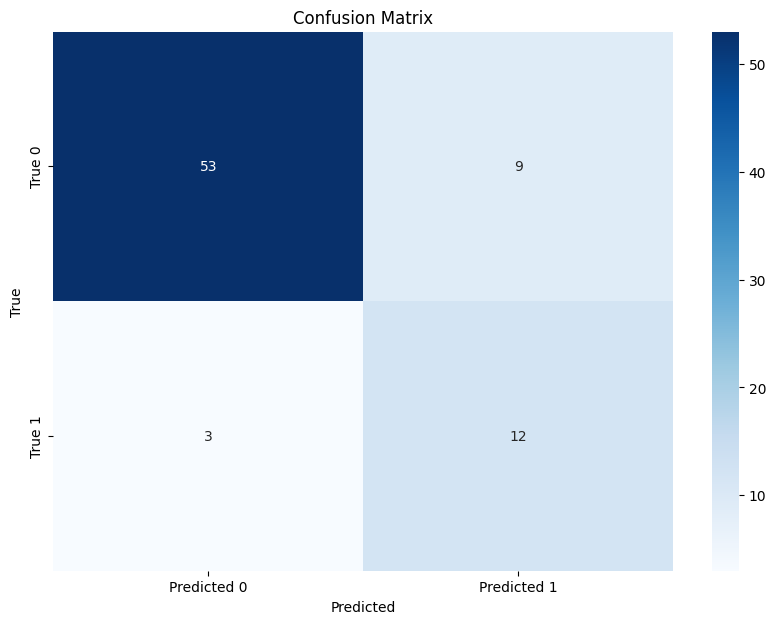

Learning Rate: 5e-05 - Validation Accuracy: 0.8441558441558441


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 3.6640, Val loss = 19.8122
Epoch 1: Train loss = 2.8060, Val loss = 15.3095
Epoch 2: Train loss = 2.3172, Val loss = 13.3700
Epoch 3: Train loss = 2.0299, Val loss = 12.1328
Epoch 4: Train loss = 1.8736, Val loss = 11.2201
Epoch 5: Train loss = 1.8280, Val loss = 11.3437
Epoch 6: Train loss = 1.7562, Val loss = 11.1808
Epoch 7: Train loss = 1.6946, Val loss = 10.7786
Epoch 8: Train loss = 1.6318, Val loss = 10.5986
Epoch 9: Train loss = 1.5979, Val loss = 9.9271
Epoch 10: Train loss = 1.5210, Val loss = 9.4675
Epoch 11: Train loss = 1.3753, Val loss = 9.1845
Epoch 12: Train loss = 1.2707, Val loss = 9.3483
Epoch 13: Train loss = 1.3951, Val loss = 9.9456
Epoch 14: Train loss = 1.2216, Val loss = 9.0906
Epoch 15: Train loss = 1.2631, Val loss = 9.3249
Epoch 16: Train loss = 1.0684, Val loss = 8.9684
Epoch 17: Train loss = 1.0611, Val loss = 8.9739
Epoch 18: Train loss = 1.0013, Val loss = 9.0026
Epoch 19: Train loss = 0.9198, Val loss = 9.5763
Epoch 20: Train loss 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[58  4]
 [ 6  9]]


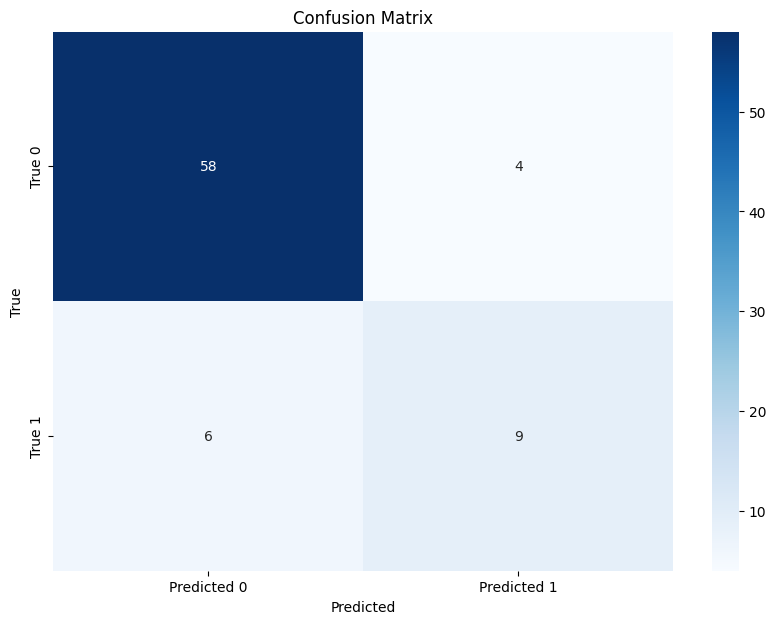

Learning Rate: 1e-05 - Validation Accuracy: 0.8701298701298701


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: Train loss = 6.1864, Val loss = 38.2609
Epoch 1: Train loss = 6.0395, Val loss = 38.8255
Epoch 2: Train loss = 5.8793, Val loss = 37.6123
Epoch 3: Train loss = 5.7355, Val loss = 35.6851
Epoch 4: Train loss = 5.5779, Val loss = 34.8866
Epoch 5: Train loss = 5.4625, Val loss = 34.6993
Epoch 6: Train loss = 5.2748, Val loss = 34.2003
Epoch 7: Train loss = 5.1549, Val loss = 33.1962
Epoch 8: Train loss = 5.0063, Val loss = 32.0105
Epoch 9: Train loss = 4.8775, Val loss = 30.7301
Epoch 10: Train loss = 4.7666, Val loss = 30.1442
Epoch 11: Train loss = 4.6186, Val loss = 29.4209
Epoch 12: Train loss = 4.4746, Val loss = 28.5997
Epoch 13: Train loss = 4.3568, Val loss = 27.5073
Epoch 14: Train loss = 4.2493, Val loss = 27.0074
Epoch 15: Train loss = 4.1275, Val loss = 26.2532
Epoch 16: Train loss = 4.0278, Val loss = 25.2119
Epoch 17: Train loss = 3.9004, Val loss = 25.0201
Epoch 18: Train loss = 3.7993, Val loss = 24.2209
Epoch 19: Train loss = 3.6691, Val loss = 23.7417
Epoch 20: 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


True labels unique values: [0 1] Type: int64
Predicted labels unique values: [0 1] Type: int64
Confusion Matrix:
 [[17 45]
 [ 4 11]]


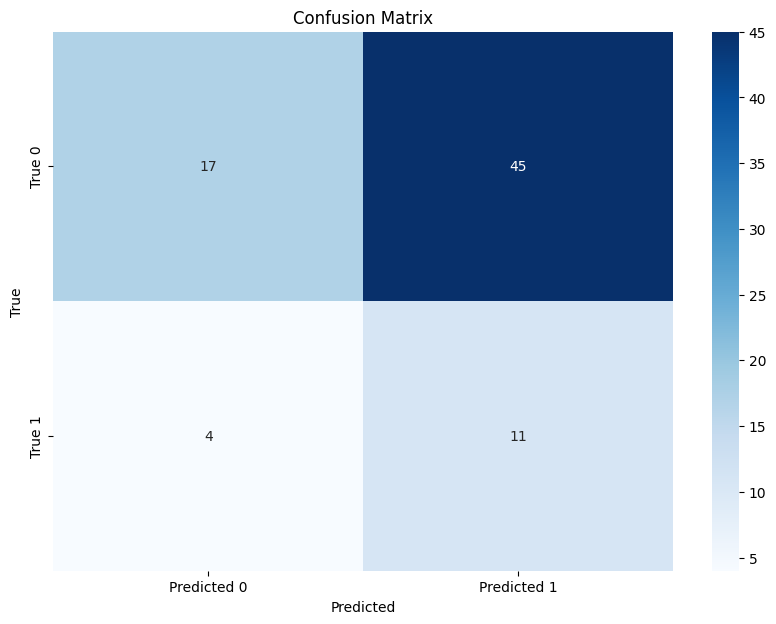

Learning Rate: 1e-06 - Validation Accuracy: 0.36363636363636365


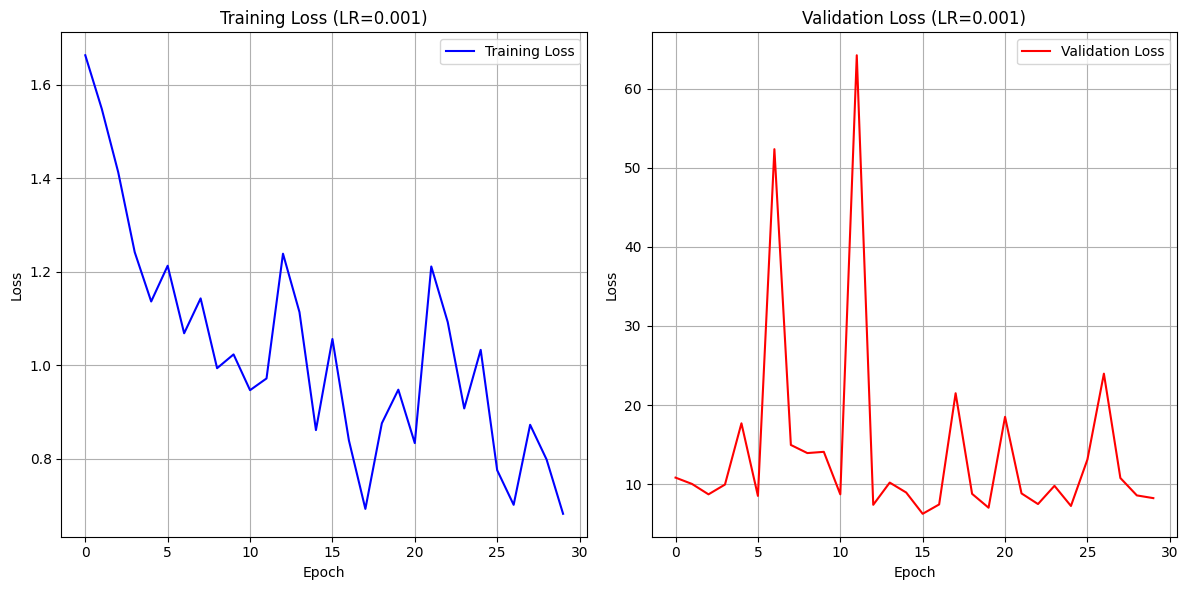

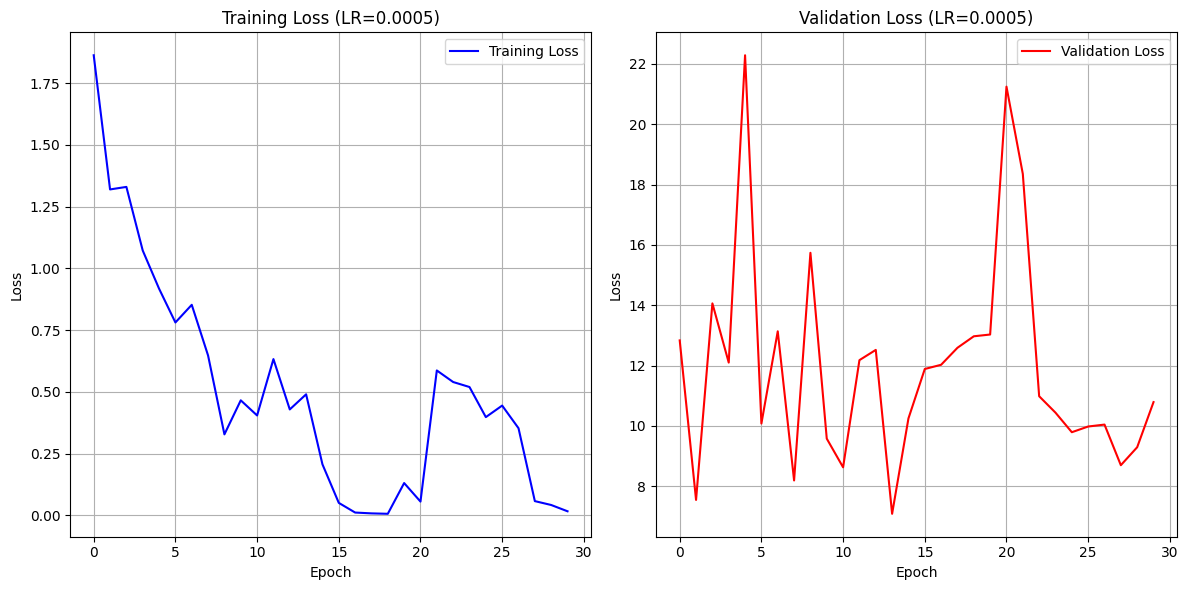

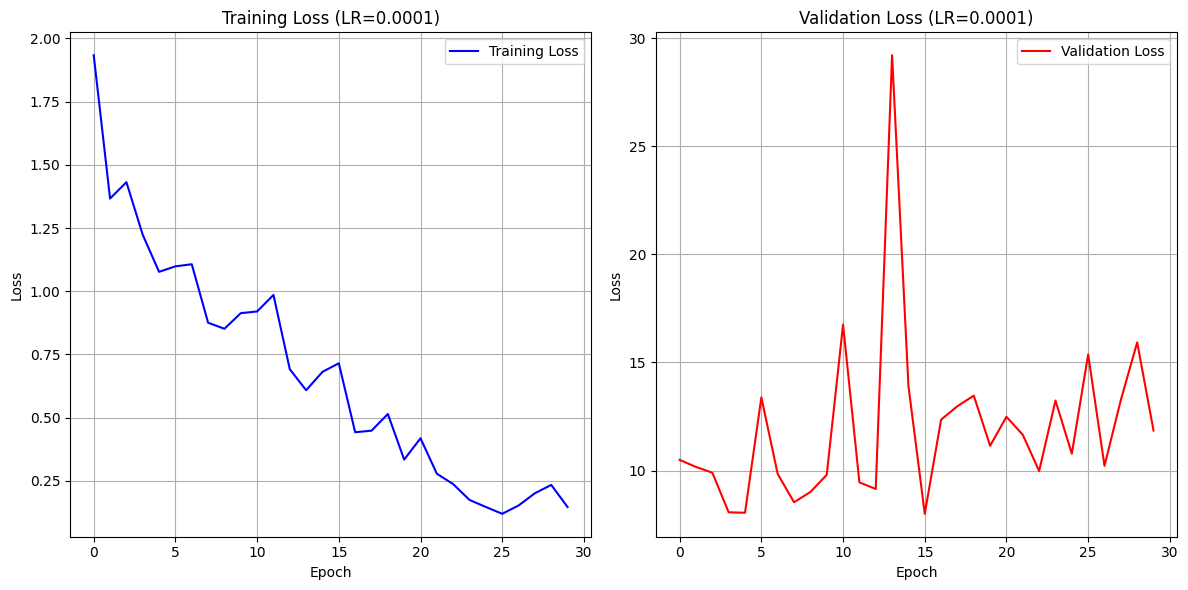

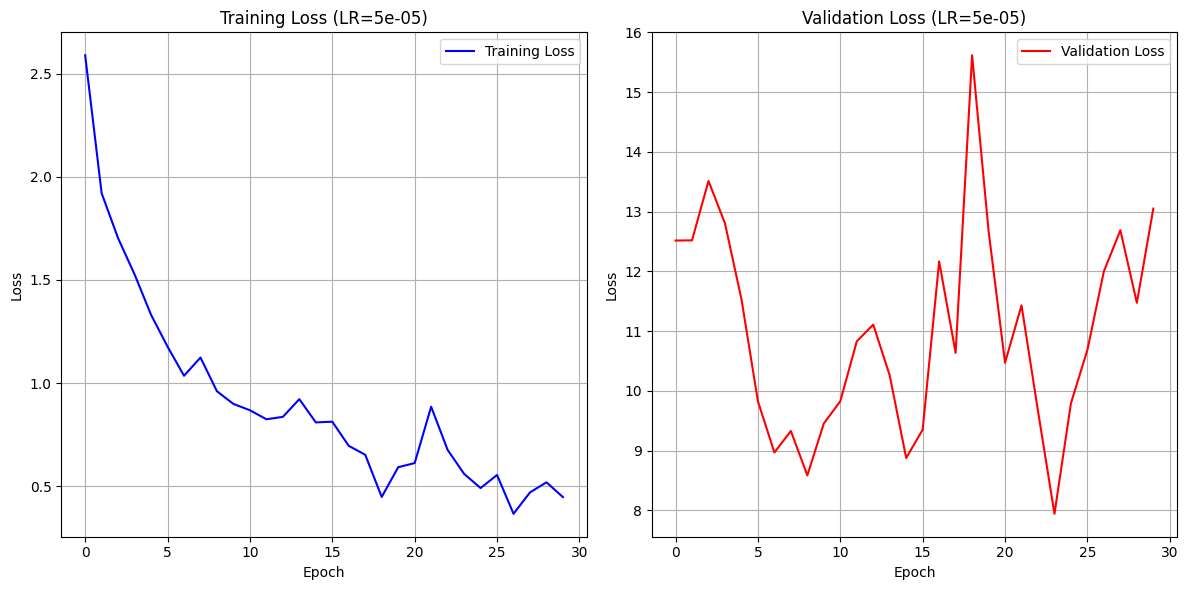

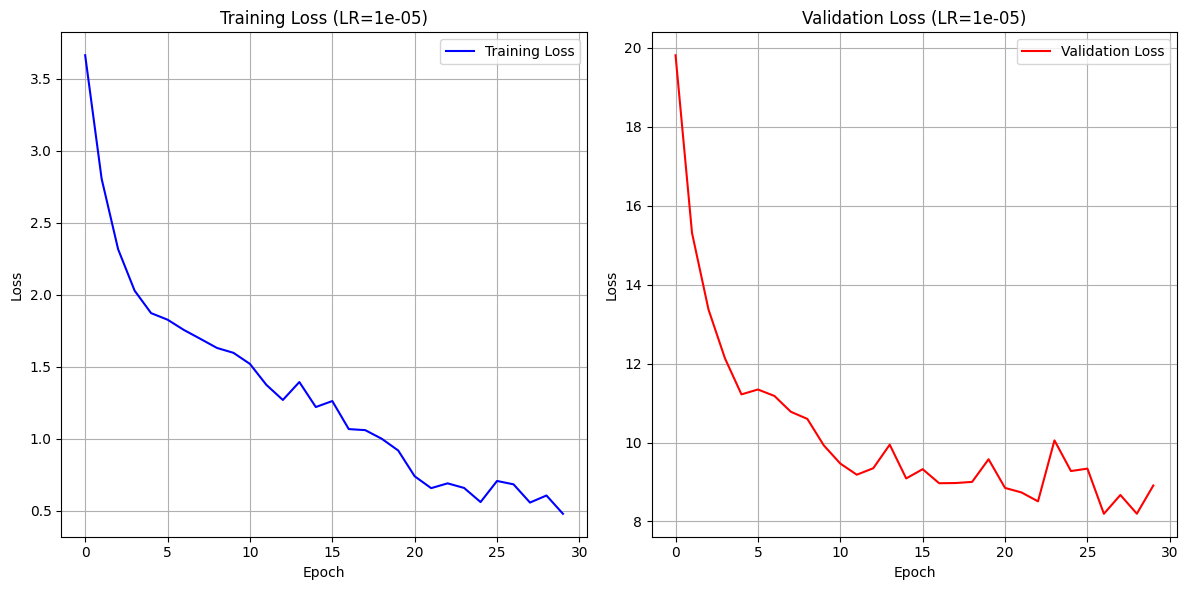

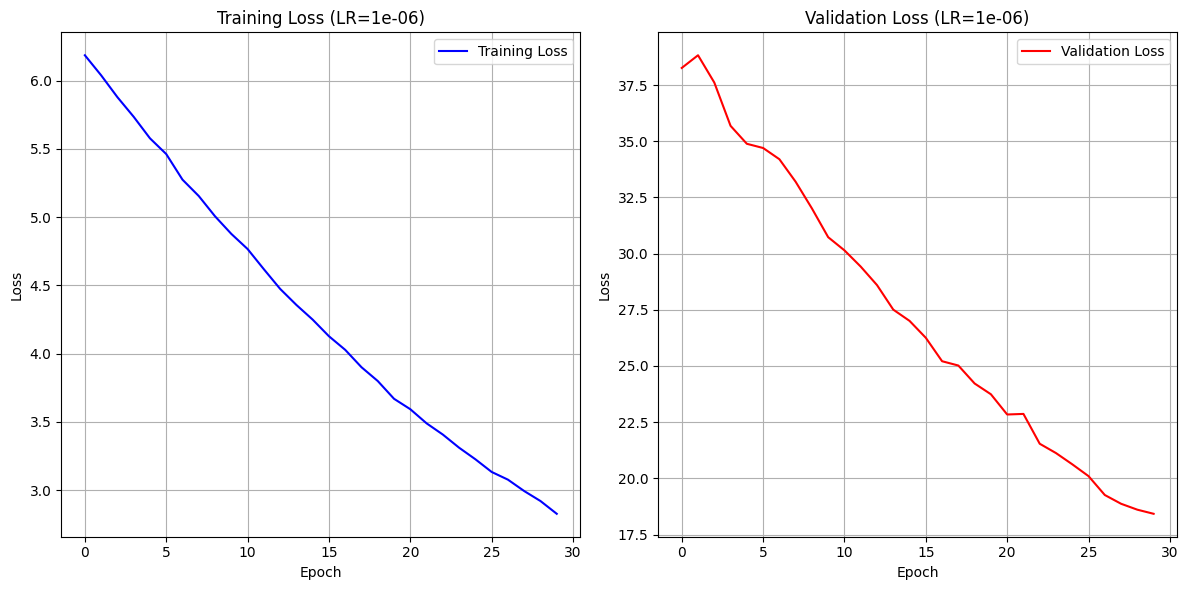

In [ ]:
import itertools
# Path setup, dataset, and transforms

image_directory = path.join('OASIS-1_dataset', 'CAPS')
list_transforms = CropRightHippoCampus(2)

train_RightHippoCampus = ds_MRI(image_directory, ds_train, list_transforms=list_transforms)
test_RightHippoCampus = ds_MRI(image_directory, ds_test, list_transforms=list_transforms)

# Hyperparameter setup
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 1e-6]
n_epochs = 30
batch_size = 4
loss_histories = {}

# Training and validation setup
for lr in learning_rates:
    model_RightHippoCampus = CustomResNet3D(BottleneckBlock3D, [3, 4, 23, 3], num_classes=2).cuda()
    optimizer = torch.optim.Adam(model_RightHippoCampus.parameters(), lr=lr)
    trainloader_RightHC = DataLoader(train_RightHippoCampus, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    testloader_RightHC = DataLoader(test_RightHippoCampus, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

    # Train and evaluate the model
    best_model, losses = train(model_RightHippoCampus, trainloader_RightHC, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda(), optimizer, n_epochs)
    loss_histories[lr] = losses

    # Evaluate the model
    valid_resultsLeftHC_df, valid_metricsLeftHC  = test(best_model, testloader_RightHC, nn.CrossEntropyLoss(reduction='sum').cuda())
    print(f"Learning Rate: {lr} - Validation Accuracy: {valid_metricsLeftHC['accuracy']}")

# Plot losses for each learning rate
plot_losses_per_lr(loss_histories)